In [1]:
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt
import seaborn as sns

from comet_ml import Experiment
from comet_ml.integration.sklearn import log_model

from dotenv import load_dotenv, find_dotenv
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn import metrics 
from sklearn.metrics import roc_curve, auc

import warnings
warnings.filterwarnings('ignore')

import pickle
load_dotenv(find_dotenv())

COMET_API_KEY = os.environ.get("COMET_API_KEY")
from comet_ml.api import API
import sys

sys.path.append('/Users/xiongyuyang/Documents/_Master/IFT6758/NHL-DataScience-lIFT-6758')  # Add the root project directory path
api = API() 

from src.utils.utils import *
from src.utils.plot_graphe import *
from src.utils.result_plot_utils import *

from src.utils.result_plot_utils import plot_calibration_multi, plot_cumu_goal_multi, plot_goal_ratio_multi, plot_roc_multi

# Playoffs test results

In [2]:
test_df = pd.read_csv("../../data/FE2/test_P.csv")
test_df.isna().sum()

shotType             0
distance             0
angle                0
isGoal               0
emptyNet             0
eventPeriod          0
x                    0
y                    0
game_time            0
timeFromLastEvent    0
prevEventType        0
distFromPrev         0
prevEventX           0
prevEventY           0
isRebound            0
changeInAngle        0
speed                0
dtype: int64

## baselines

In [3]:
api.download_registry_model("ift6758-milestone2-udem", "baseline_model_angle", version="1.0.0", output_path="../../models", expand=True, stage=None)
with open("../../models/baseline_model_angle.pkl", 'rb') as m:
    baseline_model_angle = pickle.load(m)
    
baseline_angle_preds = baseline_model_angle.predict_proba(test_df[['angle']].fillna(test_df['angle'].mode()))

api.download_registry_model("ift6758-milestone2-udem", "baseline_model_ditance", version="1.0.0", output_path="../../models", expand=True, stage=None)
with open("../../models/baseline_model_ditance.pkl", 'rb') as m:
    baseline_model_distance = pickle.load(m)
baseline_dist_preds = baseline_model_distance.predict_proba(test_df[['distance']].fillna(test_df['distance'].mode()))

api.download_registry_model("ift6758-milestone2-udem", "baseline_model_distance-angle", version="1.0.0", output_path="../../models", expand=True, stage=None)
with open("../../models/baseline_model_distance+angle.pkl", 'rb') as m:
    baseline_model_distance_angle = pickle.load(m)
baseline_dist_angle_preds = baseline_model_distance_angle.predict_proba(test_df[['distance', 'angle']].fillna(test_df[['distance', 'angle']].mode()))

COMET INFO: Downloading registry model 'baseline_model_angle', version '1.0.0', stage None from workspace 'ift6758-milestone2-udem'...
COMET INFO: Unzipping model to '/Users/xiongyuyang/Documents/_Master/IFT6758/NHL-DataScience-lIFT-6758/models' ...
COMET INFO: done!
COMET INFO: Downloading registry model 'baseline_model_ditance', version '1.0.0', stage None from workspace 'ift6758-milestone2-udem'...
COMET INFO: Unzipping model to '/Users/xiongyuyang/Documents/_Master/IFT6758/NHL-DataScience-lIFT-6758/models' ...
COMET INFO: done!
COMET INFO: Downloading registry model 'baseline_model_distance-angle', version '1.0.0', stage None from workspace 'ift6758-milestone2-udem'...
COMET INFO: Unzipping model to '/Users/xiongyuyang/Documents/_Master/IFT6758/NHL-DataScience-lIFT-6758/models' ...
COMET INFO: done!


## Random Forest

In [4]:
def replace_inf_RF(df, feature):
    max = np.sort(df[feature].unique())[-3]
    return df[feature].replace(np.inf,max)

In [5]:
api.download_registry_model("ift6758-milestone2-udem", "RandomForest_1", version="1.0.0", output_path="../../models", expand=True, stage=None)
with open("../../models/RandomForest_1.pkl", 'rb') as m:
    rf_model = pickle.load(m)

X_test_playoffs = test_df[['distance', 'angle', 'game_time', 'speed']]
new_speed_test_playoffs = replace_inf_RF(X_test_playoffs, "speed")
X_test_playoffs.speed = new_speed_test_playoffs 
y_test_playoffs = test_df['isGoal']

rf_prediction_playoffs = rf_model.predict_proba(X_test_playoffs)

COMET INFO: Downloading registry model 'RandomForest_1', version '1.0.0', stage None from workspace 'ift6758-milestone2-udem'...
COMET INFO: Unzipping model to '/Users/xiongyuyang/Documents/_Master/IFT6758/NHL-DataScience-lIFT-6758/models' ...
COMET INFO: done!


## XGBoost

In [6]:
api.download_registry_model("ift6758-milestone2-udem", "xgboost_3", version="1.0.0", output_path="../../models", expand=True, stage=None)
with open("../../models/XGBoost_3.pkl", 'rb') as m:
    xg_model = pickle.load(m)

features_selected = ['y',
 'speed',
 'shotType_Snap Shot',
 'isRebound',
 'shotType_Wrap-around',
 'game_time',
 'shotType_Wrist Shot',
 'eventPeriod',
 'timeFromLastEvent',
 'shotType_Slap Shot',
 'shotType_Backhand',
 'prevEventType_HIT',
 'angle',
 'prevEventType_STOP',
 'distance',
 ]

test_oneHot = pre_processing(test_df ,oneHot=True)
X, y = get_X_y(test_oneHot)
cols_when_model_builds = xg_model.get_booster().feature_names
X_test_xg = X[cols_when_model_builds]

preds_xg = xg_model.predict_proba(X[cols_when_model_builds])

COMET INFO: Downloading registry model 'xgboost_3', version '1.0.0', stage None from workspace 'ift6758-milestone2-udem'...
COMET INFO: Unzipping model to '/Users/xiongyuyang/Documents/_Master/IFT6758/NHL-DataScience-lIFT-6758/models' ...
COMET INFO: done!


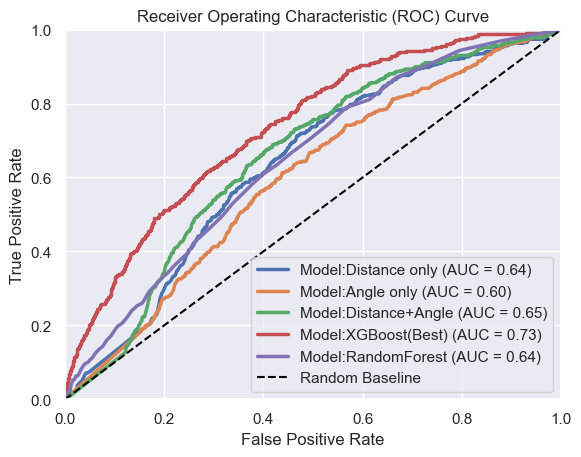

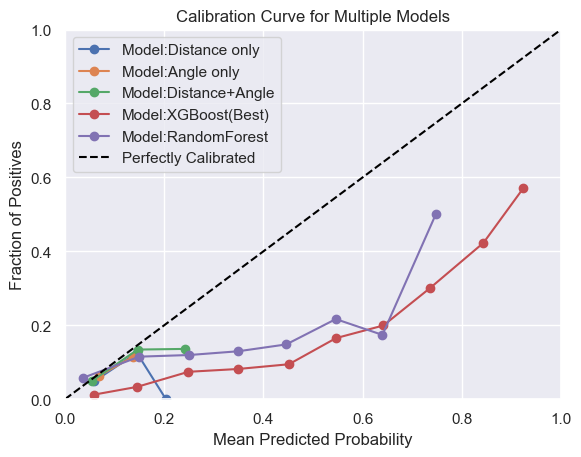

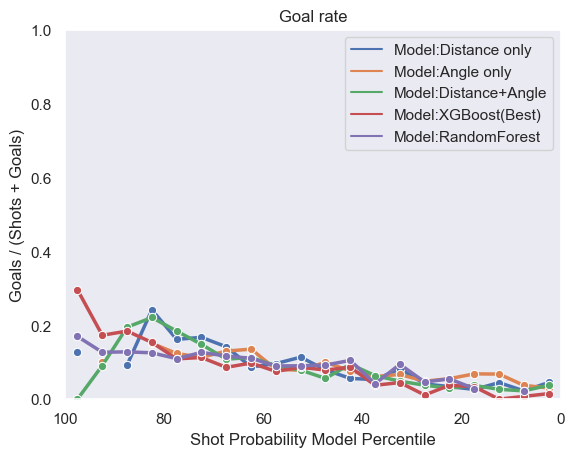

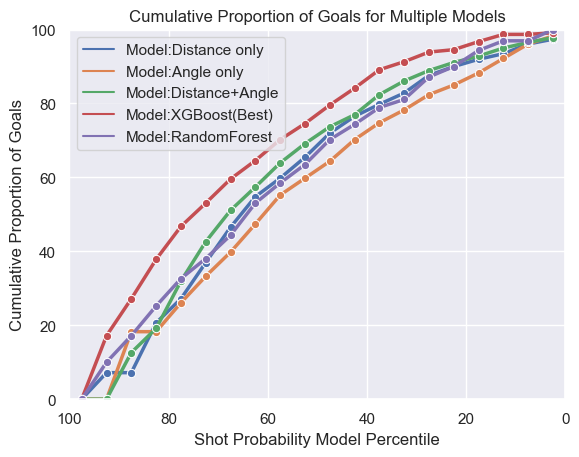

In [7]:
models = [('Model:Distance only', baseline_dist_preds[:, 1]), ('Model:Angle only', baseline_angle_preds[:, 1]), ('Model:Distance+Angle', baseline_dist_angle_preds[:, 1]), ('Model:XGBoost(Best)', preds_xg[:,1]), ('Model:RandomForest', rf_prediction_playoffs[:,1])]


plot_roc_multi(models, test_df[['isGoal']].values.reshape(-1))
plot_calibration_multi(models, test_df[['isGoal']].values.reshape(-1))
plot_goal_ratio_multi(models, test_df[['isGoal']].values.reshape(-1))
plot_cumu_goal_multi(models, test_df[['isGoal']].values.reshape(-1))


## Regular Test results

In [8]:
test_df = pd.read_csv("../../data/FE2/test_R.csv")

## Baselines

In [9]:
api.download_registry_model("ift6758-milestone2-udem", "baseline_model_angle", version="1.0.0", output_path="../../models", expand=True, stage=None)
with open("../../models/baseline_model_angle.pkl", 'rb') as m:
    baseline_model_angle = pickle.load(m)
    
baseline_angle_preds = baseline_model_angle.predict_proba(test_df[['angle']].fillna(test_df['angle'].mode()))

api.download_registry_model("ift6758-milestone2-udem", "baseline_model_ditance", version="1.0.0", output_path="../../models", expand=True, stage=None)
with open("../../models/baseline_model_ditance.pkl", 'rb') as m:
    baseline_model_distance = pickle.load(m)
baseline_dist_preds = baseline_model_distance.predict_proba(test_df[['distance']].fillna(test_df['distance'].mode()))

api.download_registry_model("ift6758-milestone2-udem", "baseline_model_distance-angle", version="1.0.0", output_path="../../models", expand=True, stage=None)
with open("../../models/baseline_model_distance+angle.pkl", 'rb') as m:
    baseline_model_distance_angle = pickle.load(m)
baseline_dist_angle_preds = baseline_model_distance_angle.predict_proba(test_df[['distance', 'angle']].fillna(test_df[['distance', 'angle']].mode()))
 

COMET INFO: Downloading registry model 'baseline_model_angle', version '1.0.0', stage None from workspace 'ift6758-milestone2-udem'...
COMET INFO: Unzipping model to '/Users/xiongyuyang/Documents/_Master/IFT6758/NHL-DataScience-lIFT-6758/models' ...
COMET INFO: done!
COMET INFO: Downloading registry model 'baseline_model_ditance', version '1.0.0', stage None from workspace 'ift6758-milestone2-udem'...
COMET INFO: Unzipping model to '/Users/xiongyuyang/Documents/_Master/IFT6758/NHL-DataScience-lIFT-6758/models' ...
COMET INFO: done!
COMET INFO: Downloading registry model 'baseline_model_distance-angle', version '1.0.0', stage None from workspace 'ift6758-milestone2-udem'...
COMET INFO: Unzipping model to '/Users/xiongyuyang/Documents/_Master/IFT6758/NHL-DataScience-lIFT-6758/models' ...
COMET INFO: done!


## Random forest

In [10]:
api.download_registry_model("ift6758-milestone2-udem", "RandomForest_1", version="1.0.0", output_path="../../models", expand=True, stage=None)
with open("../../models/RandomForest_1.pkl", 'rb') as m:
    rf_model = pickle.load(m)

X_test_reg = test_df[['distance', 'angle', 'game_time', 'speed']]
new_speed_test_reg = replace_inf_RF(X_test_reg, "speed")
X_test_reg.speed = new_speed_test_reg 
y_test_reg = test_df['isGoal']

rf_prediction_reg = rf_model.predict_proba(X_test_reg)

COMET INFO: Downloading registry model 'RandomForest_1', version '1.0.0', stage None from workspace 'ift6758-milestone2-udem'...
COMET INFO: Unzipping model to '/Users/xiongyuyang/Documents/_Master/IFT6758/NHL-DataScience-lIFT-6758/models' ...
COMET INFO: done!


## XGBoost

In [11]:
api.download_registry_model("ift6758-milestone2-udem", "xgboost_3", version="1.0.0", output_path="../../models", expand=True, stage=None)
with open("../../models/XGBoost_3.pkl", 'rb') as m:
    xg_model = pickle.load(m)

features_selected = ['y',
 'speed',
 'shotType_Snap Shot',
 'isRebound',
 'shotType_Wrap-around',
 'game_time',
 'shotType_Wrist Shot',
 'eventPeriod',
 'timeFromLastEvent',
 'shotType_Slap Shot',
 'shotType_Backhand',
 'prevEventType_HIT',
 'angle',
 'prevEventType_STOP',
 'distance',
 ]

test_oneHot = pre_processing(test_df ,oneHot=True)
X, y = get_X_y(test_oneHot)
cols_when_model_builds = xg_model.get_booster().feature_names
X_test_xg = X[cols_when_model_builds]

preds_xg = xg_model.predict_proba(X[cols_when_model_builds])

COMET INFO: Downloading registry model 'xgboost_3', version '1.0.0', stage None from workspace 'ift6758-milestone2-udem'...
COMET INFO: Unzipping model to '/Users/xiongyuyang/Documents/_Master/IFT6758/NHL-DataScience-lIFT-6758/models' ...
COMET INFO: done!


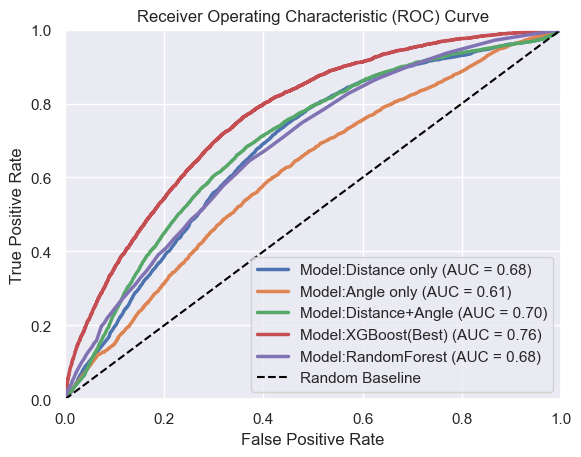

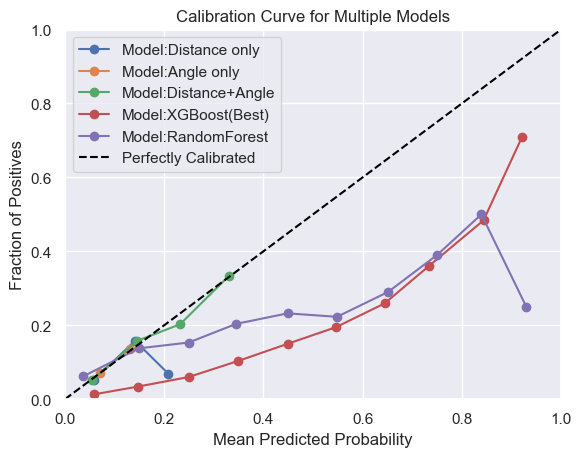

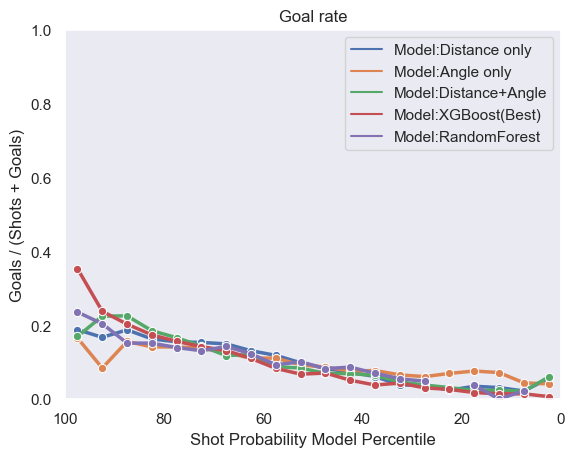

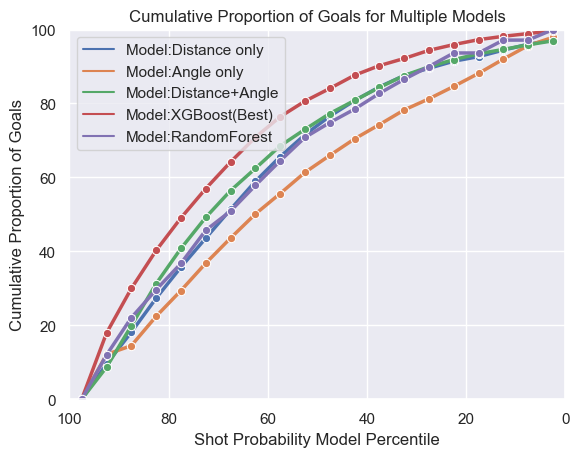

In [12]:
models = [('Model:Distance only', baseline_dist_preds[:, 1]), ('Model:Angle only', baseline_angle_preds[:, 1]), ('Model:Distance+Angle', baseline_dist_angle_preds[:, 1]), ('Model:XGBoost(Best)', preds_xg[:,1]), ('Model:RandomForest', rf_prediction_reg[:,1])]


plot_roc_multi(models, test_df[['isGoal']].values.reshape(-1))
plot_calibration_multi(models, test_df[['isGoal']].values.reshape(-1))
plot_goal_ratio_multi(models, test_df[['isGoal']].values.reshape(-1))
plot_cumu_goal_multi(models, test_df[['isGoal']].values.reshape(-1))


In [13]:
!ls

BestModels.ipynb              __init__.py
FinalTestRun.ipynb            __pycache__
PCA_feature_engineering.ipynb baseline_experiments.ipynb
RandomForest.ipynb            mlp.ipynb
XGBoost.ipynb


In [15]:
!pwd

/Users/xiongyuyang/Documents/_Master/IFT6758/NHL-DataScience-lIFT-6758/notebooks/experiments
